# Logistic Regression with TensorFlow

## Its function and graph

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

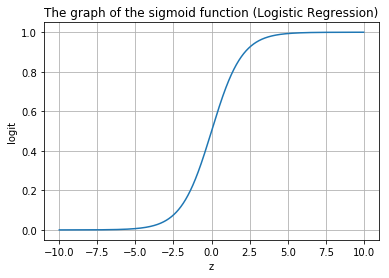

In [2]:
z = np.arange(-10, 10, 0.01)
logit = 1 / (1 + np.exp(-z))
plt.plot(z, logit)
plt.xlabel('z')
plt.ylabel('logit')
plt.title('The graph of the sigmoid function (Logistic Regression)')
plt.grid(True)

## TensorFlow Implementation

In [3]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_probability = 1 / (1 + tf.exp(-logits))

        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_probability, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
            
    return y_probability, loss, training_op, init

## Prepare the moons dataset

In [4]:
from sklearn.datasets import make_moons

n_samples = 1000
X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.1)

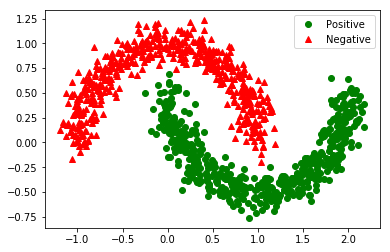

In [5]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [6]:
# Reshape the y part to make it able to be used
y_moons = y_moons.reshape(-1, 1)

In [7]:
test_ratio = 0.2
test_size = int(n_samples * test_ratio)
X_train = X_moons[:-test_size]
X_test = X_moons[-test_size:]
y_train = y_moons[:-test_size]
y_test = y_moons[-test_size:]

## Train and Test

In [8]:
n_inputs = X_moons.shape[1]

X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_probability, loss, training_op, init = logistic_regression(X, y, learning_rate=0.001)
saver = tf.train.Saver()

In [9]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)

loss_summary = tf.summary.scalar("LOSS", loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [10]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [11]:
n_epochs = 1001
batch_size = 50
n_batches = int(np.ceil(n_samples / batch_size))
checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

In [12]:
with tf.Session() as sess:
    
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)      
    else:
        start_epoch = 0
        sess.run(init)

        
        
    for epoch in range(start_epoch, n_epochs):
        
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val, loss_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(loss_str, epoch)
        save_path = saver.save(sess, "./my_model.ckpt")
        
        
        
        if epoch % 50 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    save_path = saver.save(sess, final_model_path)
    y_proba_val = y_probability.eval(feed_dict={X: X_test, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.644332
Epoch: 50 	Loss: 0.605539
Epoch: 100 	Loss: 0.572933
Epoch: 150 	Loss: 0.544993
Epoch: 200 	Loss: 0.521174
Epoch: 250 	Loss: 0.500689
Epoch: 300 	Loss: 0.482758
Epoch: 350 	Loss: 0.46742
Epoch: 400 	Loss: 0.453744
Epoch: 450 	Loss: 0.441764
Epoch: 500 	Loss: 0.431267
Epoch: 550 	Loss: 0.421916
Epoch: 600 	Loss: 0.413542
Epoch: 650 	Loss: 0.406073
Epoch: 700 	Loss: 0.399358
Epoch: 750 	Loss: 0.393276
Epoch: 800 	Loss: 0.387755
Epoch: 850 	Loss: 0.382883
Epoch: 900 	Loss: 0.378374
Epoch: 950 	Loss: 0.374337
Epoch: 1000 	Loss: 0.370584


## Stats and plotting predictions

In [13]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Classify each istance watching its maximum likelihood: if >= 0.5 then positive else negative
y_pred = (y_proba_val >= 0.5)

print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

0.766990291262
0.79797979798


array([[77, 24],
       [20, 79]])

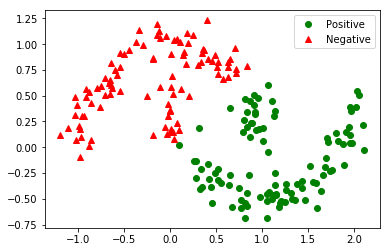

In [14]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx == 1, 0], X_test[y_pred_idx == 1, 1], 'go', label="Positive")
plt.plot(X_test[y_pred_idx == 0, 0], X_test[y_pred_idx == 0, 1], 'r^', label="Negative")
plt.legend()